In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
import mplhep as hep
plt.style.use(hep.style.ROOT)

from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras 
#import setGPU
from numpy.random import seed
import tensorflow as tf
from model import model_ConvDNN, model_DNN
from keras import regularizers, Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import mean_absolute_error, MeanAbsoluteError, mean_squared_error, MeanSquaredError

In [5]:
model_outdir = 'DNN_v1_totalcharge_energyreg_final_200PU_8x8_c8_S2_pair_mse'
model_name = 'best_model_DNN'
model_type = 'DNN' 

In [6]:
test_truth = np.load('{}/prediction_truth_PU200_8x8_c8_S2_pair_mse.npy'.format(model_outdir))
test_pred = np.squeeze(np.load('{}/prediction_test_PU200_8x8_c8_S2_pair_mse.npy'.format(model_outdir)))

#Sum of all tcs
test_sum_pred = np.load('{}/prediction_simplesum_PU200_8x8_c8_S2_pair_mse.npy'.format(model_outdir))

e_residual_ai = test_truth - test_pred
e_residual_sum = test_truth - test_sum_pred

In [7]:
#### DIVIDE INTO DIFFERENT ENERGY RANGES
def fit_resolution_model(emin, emax, emean, e_residual):
    
    E = 1000
    
    plt.hist(e_residual, density = True, bins = 100, range = (-E, E))

    #Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(-E, E, 101)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

    mask = data_entries!=0

    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                        sigma = np.sqrt(data_entries[mask]),
                        absolute_sigma = False, p0=[0.008, 0, 100])

    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    res_fit = std_fit/mean_fit
    sigma_res = perr[2]/mean_fit
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    print("Resolution (fit) is {}".format(res_fit))

    #Plot fitted gaussian
    plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
    plt.title("(Model) Energy range ({},{}) GeV".format(emin,emax))
    plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
    plt.legend()
    plt.show()

    return std_fit/emean, perr[2]/emean

def plot_res_with_E_model(e_residual_all, truth_e):
    
    #Data points for plotting
    E_range = []
    E_res = []
    E_err = []
    E_average = []
    
    #Loop through different energy ranges
    for i in range(0,10):
        
        emin = i*130
        emax = (i+1)*130
        
        E_range.append([emin,emax])
        
        print("Energy range: ", (emin,emax))
        
        e_residual = e_residual_all[(truth_e > emin) & (truth_e <= emax)]
        
        emean = np.mean(truth_e[(truth_e > emin) & (truth_e <= emax)])
        E_average.append(emean)
        
        res, err = fit_resolution_model(emin, emax, emean, e_residual)
        
        E_res.append(res)
        E_err.append(err)
        
    ###### Plot resolution versus energy
    #Plot momentum average
#     plt.scatter(E_average, E_res, s=180, c='#2ca02c', label = "E mean [GeV]", zorder = 10)
    
#     plt.hlines(E_res,
#                [x[0] for x in E_range],
#                [x[1] for x in E_range],
#                colors='r', lw=5,
#                label = 'E resolution (model)',
#                linestyles='solid')

#     #Plot the error bars
#     plt.errorbar([np.average(x) for x in E_range],
#                 E_res,
#                 yerr=E_err,
#                 fmt='none',
#                 elinewidth=3,
#                 capsize=8)
    
#     plt.xlabel(r'Truth E [GeV]')
#     plt.ylabel(r'$\sigma_{\Delta~E}/E_{mean}$ [GeV]')
    
#     plt.legend()
#     plt.show()
    
    #print(E_res)
    print(E_err)
    
    return

In [8]:
#### DIVIDE INTO DIFFERENT ENERGY RANGES
def fit_resolution_sum(emin, emax, emean, e_residual):
    
    E = 1500
    
    plt.hist(e_residual, density = True, bins = 100, range = (-E, E))

    #Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(-E, E, 101)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

    mask = data_entries!=0

    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                        sigma = np.sqrt(data_entries[mask]),
                        absolute_sigma = False, p0=[0.01, 0, 100])

    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    res_fit = std_fit/mean_fit
    sigma_res = perr[2]/mean_fit
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    print("Resolution (fit) is {}".format(res_fit))

    #Plot fitted gaussian
    plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
    plt.title("(Sum) Energy range ({},{}) GeV".format(emin,emax))
    plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
    plt.legend()
    plt.show()

    return std_fit/emean, perr[2]/emean

def plot_res_with_E_sum(e_residual_all, truth_e):
    
    #Data points for plotting
    E_range = []
    E_res = []
    E_err = []
    E_average = []
    
    #Loop through different energy ranges
    for i in range(0,10):
        
        emin = i*130
        emax = (i+1)*130
        
        E_range.append([emin,emax])
        
        print("Energy range: ", (emin,emax))
        
        e_residual = e_residual_all[(truth_e > emin) & (truth_e <= emax)]
        
        emean = np.mean(truth_e[(truth_e > emin) & (truth_e <= emax)])
        E_average.append(emean)
        
        res, err = fit_resolution_sum(emin, emax, emean, e_residual)
        
        E_res.append(res)
        E_err.append(err)
        
    ###### Plot resolution versus energy
    #Plot momentum average
#     plt.scatter(E_average, E_res, s=180, c='#2ca02c', zorder = 10)
    
#     plt.hlines(E_res,
#                [x[0] for x in E_range],
#                [x[1] for x in E_range],
#                colors='y', lw=5,
#                label = 'E resolution (sum)',
#                linestyles='solid')

#     #Plot the error bars
#     plt.errorbar([np.average(x) for x in E_range],
#                 E_res,
#                 yerr=E_err,
#                 fmt='none',
#                 elinewidth=3,
#                 capsize=8)
    
#     plt.xlabel(r'Truth E [GeV]')
#     plt.ylabel(r'$\sigma_{\Delta~E}/E_{mean}$ [%]')
    
#     plt.legend()
    
    print(E_res)
    print(E_err)
    
    return

Energy range:  (0, 130)
[8.15956373e-04 1.08290593e+00 8.15954778e-01]
Standard deviation (fit) is 25.53569650837399
Mean (fit) is -3.2965008417121147
Resolution (fit) is -7.746303651817493


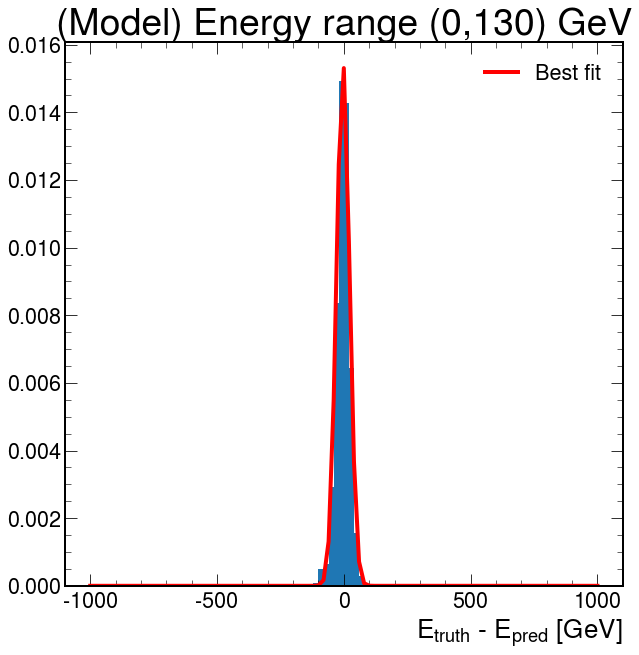

Energy range:  (130, 260)
[7.71054997e-04 1.19019808e+00 9.28639929e-01]
Standard deviation (fit) is 27.70737911160054
Mean (fit) is 6.137867554687541
Resolution (fit) is 4.514170249639907


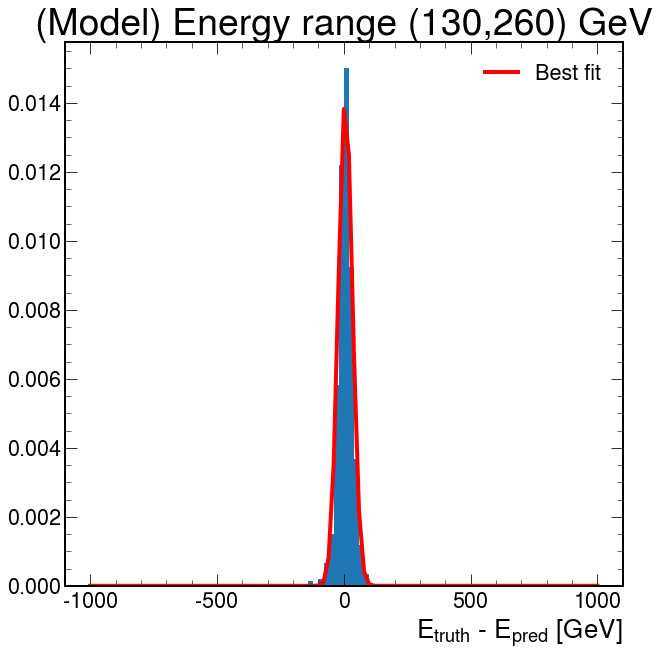

Energy range:  (260, 390)
[8.75052698e-04 1.32274603e+00 1.02732895e+00]
Standard deviation (fit) is 27.348707675893763
Mean (fit) is 0.5236471639023377
Resolution (fit) is 52.22735758193547


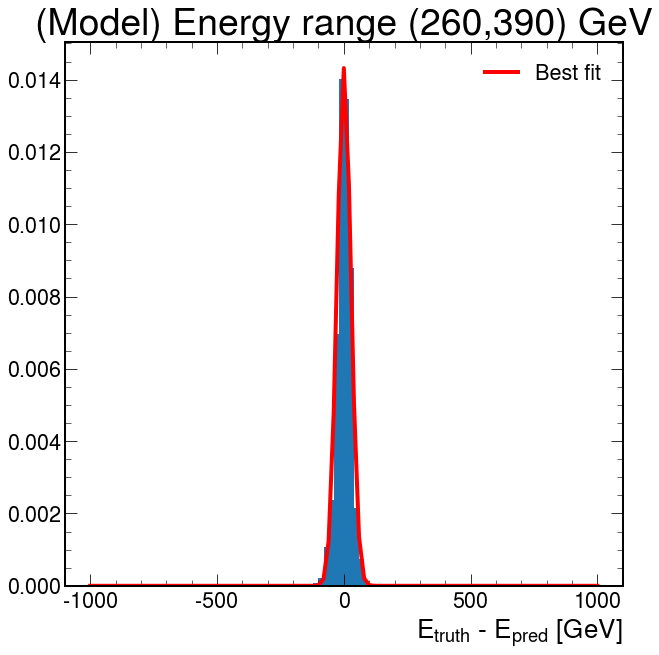

Energy range:  (390, 520)
[9.53050320e-04 1.47788482e+00 1.10226444e+00]
Standard deviation (fit) is 27.36842393492693
Mean (fit) is 1.629596149621291
Resolution (fit) is 16.79460517950242


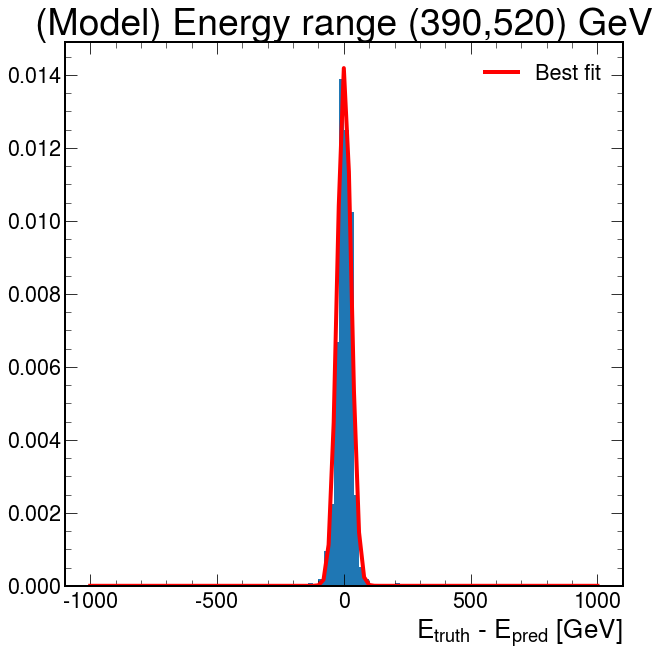

Energy range:  (520, 650)
[7.70142819e-04 1.33505955e+00 9.49795386e-01]
Standard deviation (fit) is 28.81947867132357
Mean (fit) is -2.4977131949583584
Resolution (fit) is -11.538345847511945


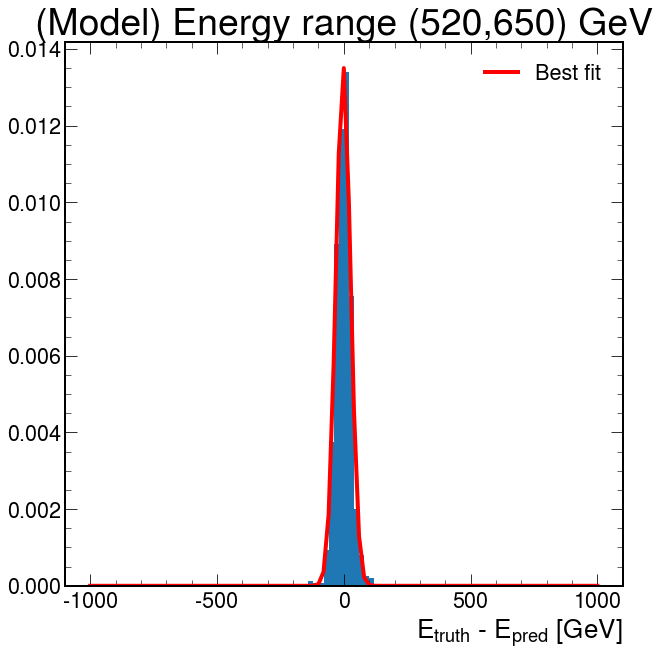

Energy range:  (650, 780)
[6.56093497e-04 1.16387940e+00 8.90918187e-01]
Standard deviation (fit) is 29.590640433307634
Mean (fit) is -1.4669525942591226
Resolution (fit) is -20.17150421159468


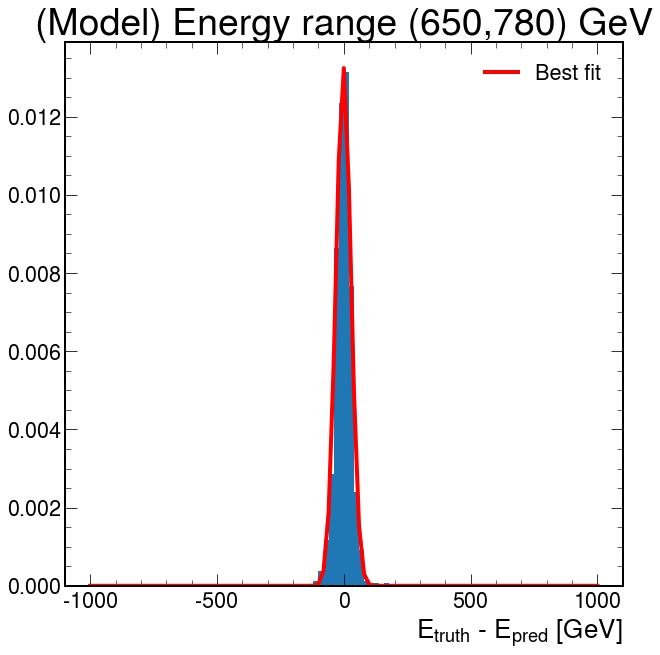

Energy range:  (780, 910)
[5.46053509e-04 9.45926880e-01 7.02977535e-01]
Standard deviation (fit) is 29.150314998801118
Mean (fit) is 2.942974871904359
Resolution (fit) is 9.905050592544933


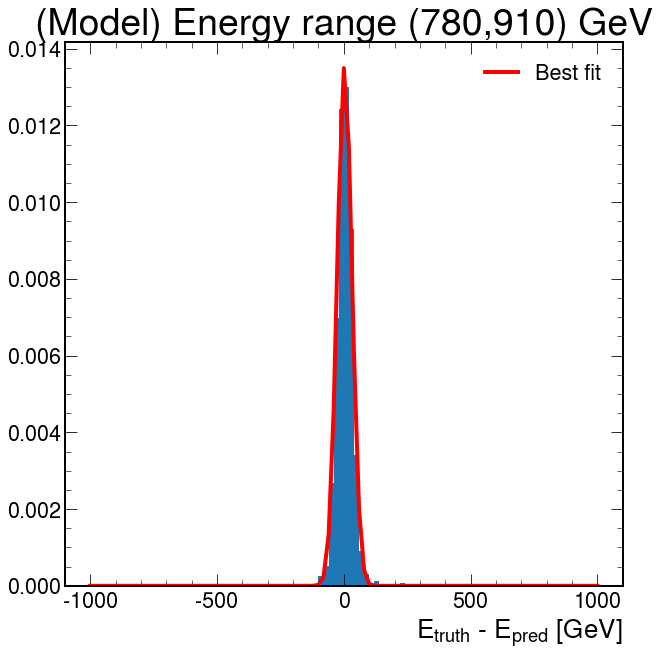

Energy range:  (910, 1040)
[4.41821070e-04 9.27831312e-01 6.96140221e-01]
Standard deviation (fit) is 32.185879598520366
Mean (fit) is 4.010505452330609
Resolution (fit) is 8.02539230555498


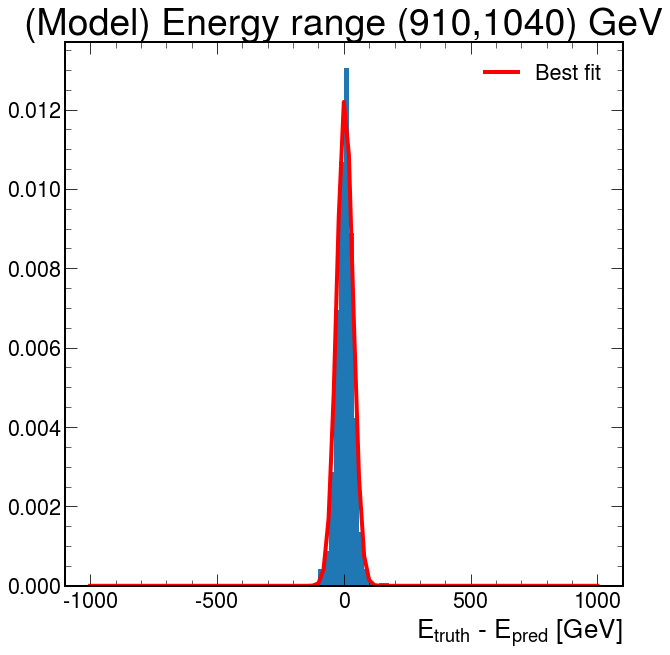

Energy range:  (1040, 1170)
[6.08413644e-04 1.42997885e+00 9.65811395e-01]
Standard deviation (fit) is 33.08758694738861
Mean (fit) is 5.314177834992401
Resolution (fit) is 6.226285226948172


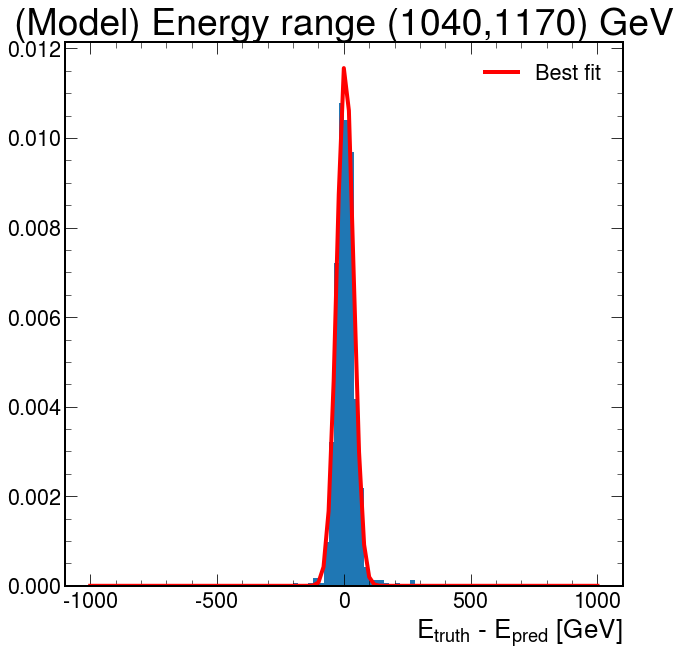

Energy range:  (1170, 1300)
[7.47584044e-04 2.02316314e+00 1.58364282e+00]
Standard deviation (fit) is 36.294467861371764
Mean (fit) is 7.631379179986316
Resolution (fit) is 4.7559513169724115


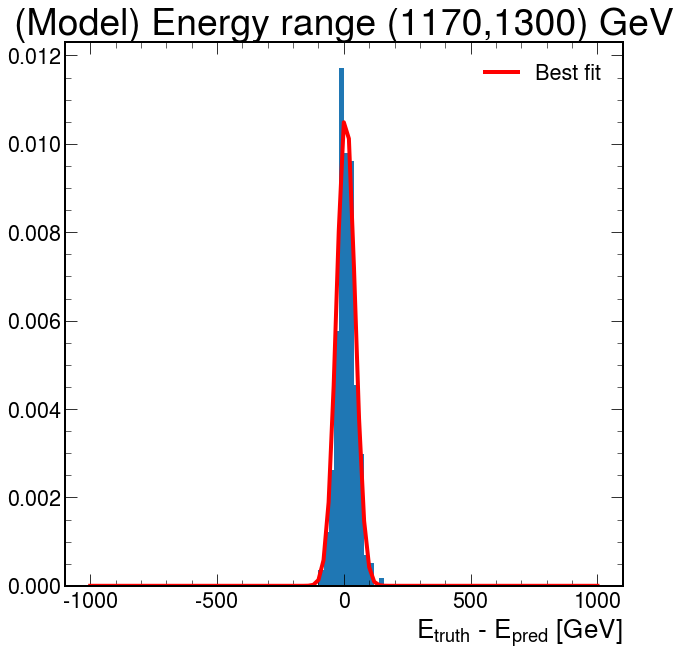

[0.01157076325923468, 0.0047492733617142315, 0.0031548129497629895, 0.0024297722276315622, 0.001623420915174732, 0.0012464926551222606, 0.0008325875469127279, 0.0007152313607974972, 0.0008731709914002314, 0.001327056630489061]
Energy range:  (0, 130)
[2.06435505e-04 4.99282669e+00 3.71662848e+00]
Standard deviation (fit) is 106.41718089223347
Mean (fit) is -859.1591199656234
Resolution (fit) is -0.12386201626596413


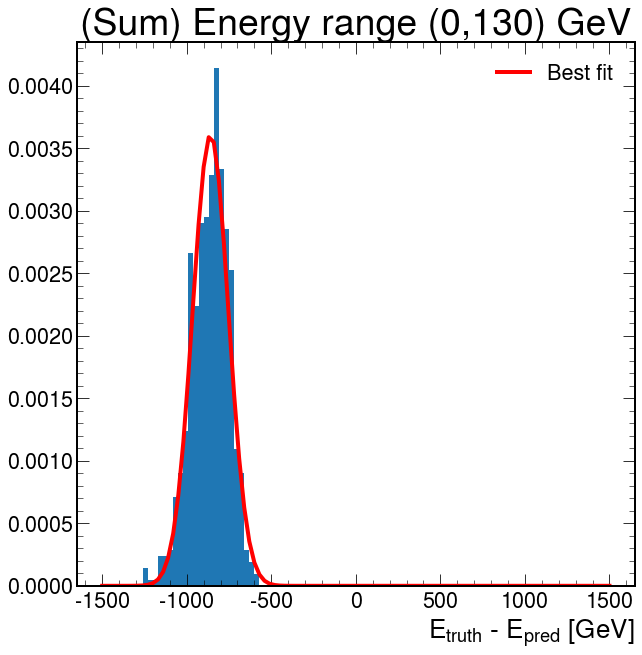

Energy range:  (130, 260)
[1.75691589e-04 4.01704808e+00 2.97066528e+00]
Standard deviation (fit) is 104.39953183491741
Mean (fit) is -854.079633036779
Resolution (fit) is -0.12223629717490486


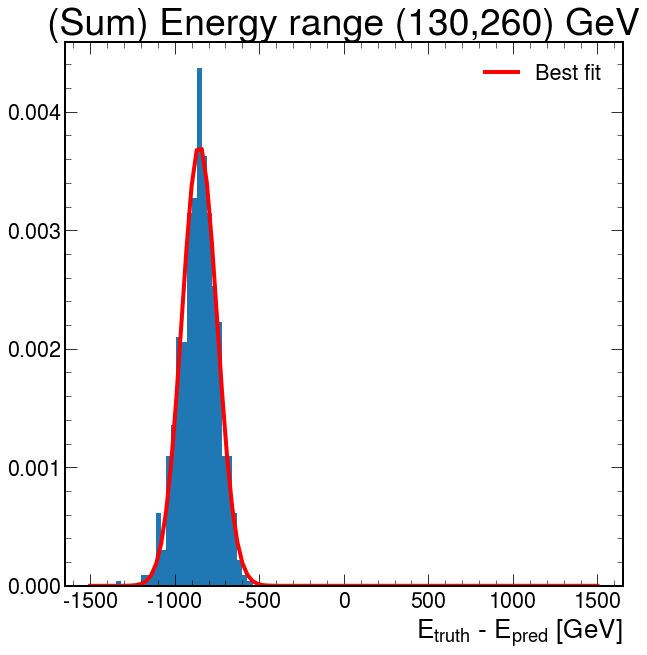

Energy range:  (260, 390)
[2.28584525e-04 4.79484016e+00 3.50998664e+00]
Standard deviation (fit) is 98.5180698007599
Mean (fit) is -838.8955715968507
Resolution (fit) is -0.1174378231765239


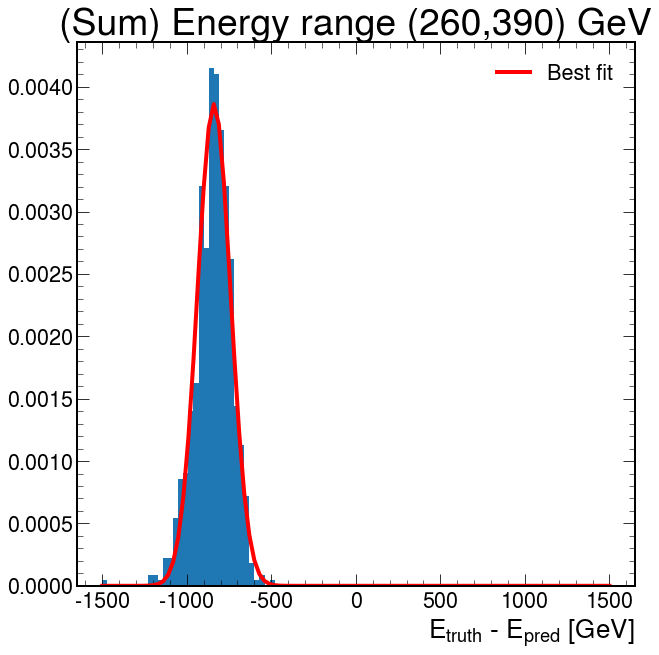

Energy range:  (390, 520)
[1.51967078e-04 3.71596328e+00 2.82470496e+00]
Standard deviation (fit) is 108.5949339422855
Mean (fit) is -856.732208264793
Resolution (fit) is -0.1267548166097681


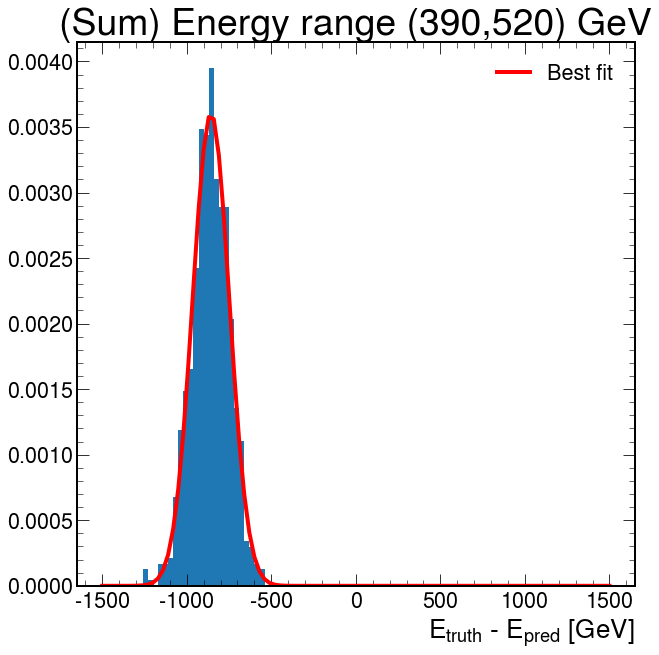

Energy range:  (520, 650)
[1.90890283e-04 4.29644965e+00 3.27964900e+00]
Standard deviation (fit) is 103.97866295836172
Mean (fit) is -843.9340996827862
Resolution (fit) is -0.12320708808595922


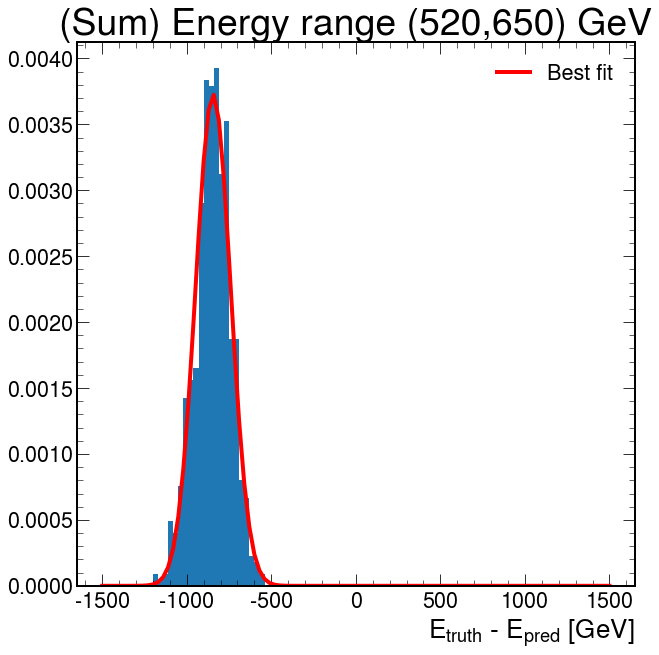

Energy range:  (650, 780)
[2.54233391e-04 5.92002964e+00 4.02889327e+00]
Standard deviation (fit) is 101.41690707025757
Mean (fit) is -840.0614827454216
Resolution (fit) is -0.12072557682184756


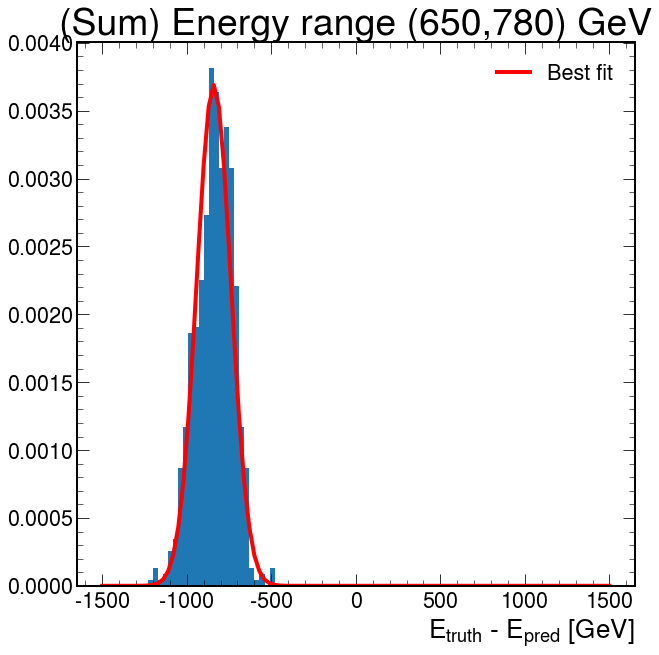

Energy range:  (780, 910)
[2.08306795e-04 4.84355865e+00 3.46646001e+00]
Standard deviation (fit) is 103.70308180687287
Mean (fit) is -837.4821351251182
Resolution (fit) is -0.12382721667415608


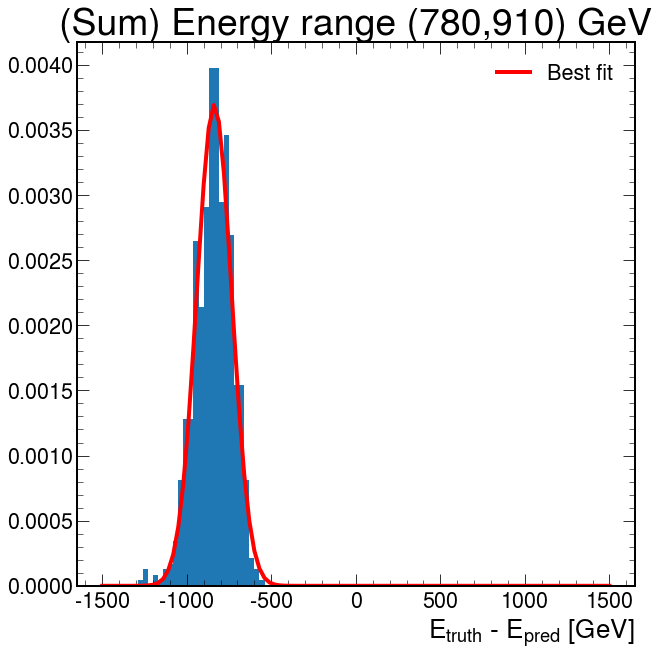

Energy range:  (910, 1040)
[2.32556358e-04 5.46005518e+00 3.90179001e+00]
Standard deviation (fit) is 103.55835369555938
Mean (fit) is -837.6545782333524
Resolution (fit) is -0.12362894728513053


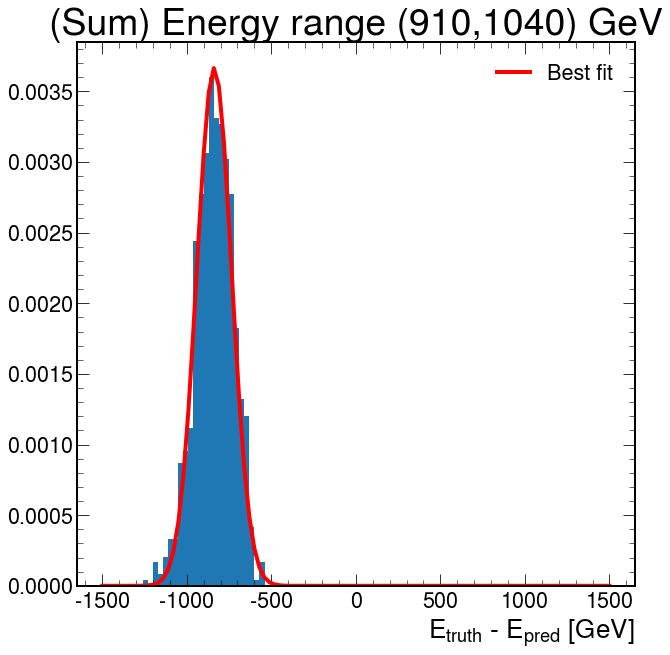

Energy range:  (1040, 1170)
[1.50442474e-04 4.02113105e+00 2.87079376e+00]
Standard deviation (fit) is 112.22313812910136
Mean (fit) is -847.3911804640965
Resolution (fit) is -0.13243368672734987


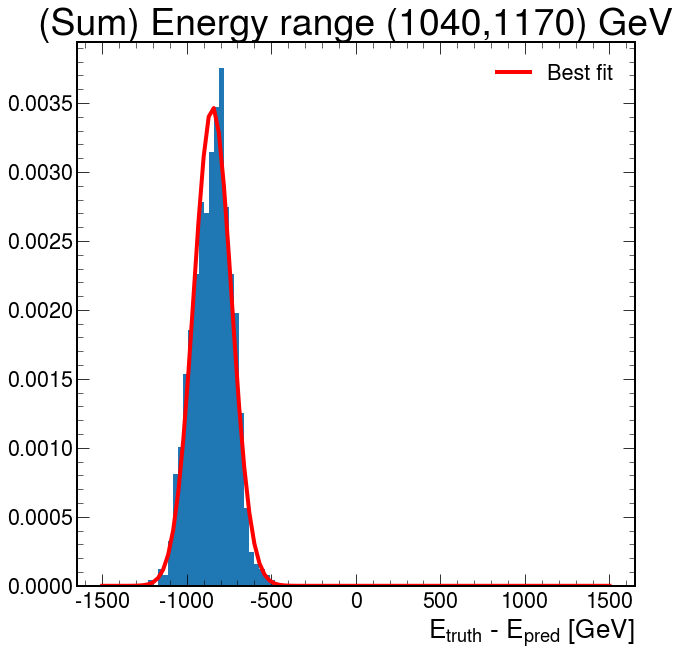

Energy range:  (1170, 1300)
[1.94490280e-04 4.81968631e+00 3.77049335e+00]
Standard deviation (fit) is 108.2972721105307
Mean (fit) is -845.1704527911703
Resolution (fit) is -0.12813660457825946


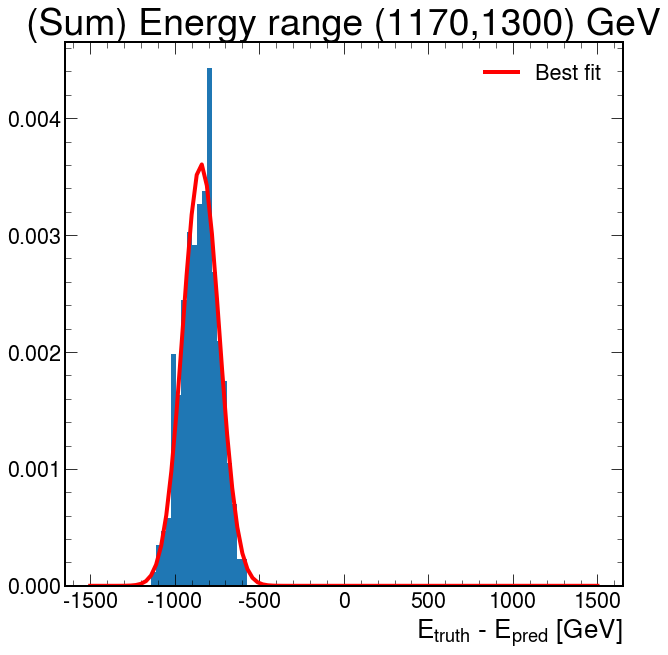

[1.5090640319814466, 0.5339226755805446, 0.30253803418478054, 0.23938081055883903, 0.1777236852531398, 0.1418934213786535, 0.12282312056983942, 0.10639836632551171, 0.10145872089535919, 0.09075064864968914]
[0.05270418093387698, 0.015192650076971174, 0.010778778555627446, 0.00622662714319226, 0.005605681869223604, 0.005636865355019498, 0.00410558131826679, 0.004008793771918624, 0.0025954278926915045, 0.0031595875897393734]


In [9]:
plot_res_with_E_model(e_residual_ai, test_truth)
plot_res_with_E_sum(e_residual_sum, test_truth)
plt.show()